In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
%reload_ext autoreload
%autoreload 1
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',100)    

display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from itertools import combinations, takewhile
import collections
import pandas as pd
import numpy as np
import os

from simhash import Simhash, SimhashIndex

sns.set()

from Utils.UtilsViz import *
from Utils.UtilsGeoViz import *

print(sys.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [3]:
fpath = os.path.join(os.getcwd(), "temp.csv")
tweets_df = pd.read_csv(fpath, index_col="Unnamed: 0")
display(
    tweets_df.shape,
    tweets_df.head()
)

(1048947, 20)

,id_str,text,in_reply_to_status_id_str,in_reply_to_user_id_str,created_at,user_id_str,user_name,user_followers_count,user_favourites_count,user_statuses_count,user_friends_count,coordinates,favorite_count,entities_hashtags,favorited,retweet_count,retweeted,retweeted_status_user_id_str,retweeted_status_user_name,hashtags_cleaned
0,8.778927e+17,RT @ArkansasBlog: Study: States with concealed carry laws experience rise in violent crime. http...,NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,1.550783e+08,Lake Man,1554.0,56574.0,95959.0,2577.0,NaN,0.0,[],False,0.0,False,17131180,Arkansas Blog,[]
1,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,7.159992e+06,Annie Williams,22.0,167.0,417.0,87.0,NaN,0.0,[],False,0.0,False,NaN,NaN,[]
2,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,8.271887e+17,Indivisible9IL,264.0,111.0,342.0,231.0,NaN,0.0,[],False,0.0,False,NaN,NaN,[]
3,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:02 +0000 2017,8.313191e+17,Indivisible Illinois,1027.0,1626.0,982.0,267.0,NaN,0.0,[],False,0.0,False,NaN,NaN,[]
4,8.778927e+17,Day 1 of Chicago Summit: Gregory Touhill delivers keynote on Cybersecurity=Risk Management #ISMG...,NaN,NaN,Thu Jun 22 14:15:02 +0000 2017,3.998460e+07,ISMG Network News,2395.0,119.0,12833.0,960.0,NaN,0.0,"[Row(indices=[91, 103], text='ISMGSummits'), Row(indices=[104, 112], text='infosec')]",False,0.0,False,NaN,NaN,"['ISMGSummits', 'infosec']"


In [4]:
from ast import literal_eval

def le(row):
    if row is np.NaN:
        return []
    else:
        return literal_eval(row)

tweets_df['hashtags_cleaned']=tweets_df['hashtags_cleaned'].apply(le)

In [5]:
tweets_df["text"].fillna(value="", inplace=True)
tweets_df["text_len"] = tweets_df["text"].apply(len)

# Q1 - Identify tweets related to UChicago and 3-4 universities of your choice

In [6]:
uc_favored_tags = ["uchicago", "uchearing", "universityofchicago", "pritzkerschoolofmedicine",
                   "uofc", "maroonmade", "chicagobooth"]
nw_favored_tags = ["northwestern"]
upenn_favored_tags = ["upenn", "penn", "uofpenn", "universityofpennsylvania", "pennlaw", "upennhearing"]
uic_favored_tags = ["UIC", "UICProud"]
mit_favored_tags = ["MIT"]
stanford_favored_tags = ["stanford"]

def is_stanford_tweet(row):
    if row is np.NaN:
        return False
    for ftag in stanford_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_upenn_tweet(row):
    if row is np.NaN:
        return False
    for ftag in upenn_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_nw_tweet(row):
    if row is np.NaN:
        return False
    for ftag in nw_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

def is_uc_tweet(row):
    if row is np.NaN:
        return False
    for ftag in uc_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_uic_tweet(row):
    if row is np.NaN:
        return False
    for ftag in uic_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

def is_mit_tweet(row):
    if row is np.NaN:
        return False
    for ftag in mit_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

tweets_df["mit_tweet"] = tweets_df["hashtags_cleaned"].apply(is_mit_tweet)
tweets_df["stanford_tweet"] = tweets_df["hashtags_cleaned"].apply(is_stanford_tweet)
tweets_df["nw_tweet"] = tweets_df["hashtags_cleaned"].apply(is_nw_tweet)
tweets_df["upenn_tweet"] = tweets_df["hashtags_cleaned"].apply(is_upenn_tweet)
tweets_df["uc_tweet"] = tweets_df["hashtags_cleaned"].apply(is_uc_tweet)
tweets_df["uic_tweet"] = tweets_df["hashtags_cleaned"].apply(is_uic_tweet)

cols = ["uc_tweet", "uic_tweet", "mit_tweet", "stanford_tweet", "upenn_tweet", "nw_tweet"]

def is_uni_tweet(row):
    for col in cols:
        if row[col]:
            return True
    else:
        return False

tweets_df["uni_tweet"] = tweets_df[cols].apply(is_uni_tweet, axis=1)

display(
    tweets_df[tweets_df["uic_tweet"]==True][["id_str", "text", "hashtags_cleaned"]].shape,
    tweets_df[tweets_df["uc_tweet"]==True][["id_str", "text", "hashtags_cleaned"]].shape,
    tweets_df[tweets_df["upenn_tweet"]==True][["id_str", "text", "hashtags_cleaned"]].shape,
    tweets_df[tweets_df["mit_tweet"]==True][["id_str", "text", "hashtags_cleaned"]].shape,
    tweets_df[tweets_df["stanford_tweet"]==True][["id_str", "text", "hashtags_cleaned"]].shape,
    tweets_df[tweets_df["nw_tweet"]==True][["id_str", "text", "hashtags_cleaned"]].shape,
    tweets_df["uni_tweet"].shape,
    tweets_df.shape
)

(133, 3)

(93, 3)

(88, 3)

(1021, 3)

(818, 3)

(214, 3)

(1048947,)

(1048947, 28)

In [7]:
uni_df = \
    tweets_df[(tweets_df["uc_tweet"]==True) | 
              (tweets_df["uic_tweet"]==True) |
              (tweets_df["mit_tweet"]==True) |
              (tweets_df["stanford_tweet"]==True) |
              (tweets_df["upenn_tweet"]==True) |
              (tweets_df["nw_tweet"]==True)]

In [8]:
uni_df.shape

(2350, 28)

# Q2 - Identify the most prolific / influential Twitterers
1. By message volume
1. By message retweet
1. How much are they tweeting about the Universities vs. other topics? 

In [9]:
uni_df.head()

,id_str,text,in_reply_to_status_id_str,in_reply_to_user_id_str,created_at,user_id_str,user_name,user_followers_count,user_favourites_count,user_statuses_count,user_friends_count,coordinates,favorite_count,entities_hashtags,favorited,retweet_count,retweeted,retweeted_status_user_id_str,retweeted_status_user_name,hashtags_cleaned,text_len,mit_tweet,stanford_tweet,nw_tweet,upenn_tweet,uc_tweet,uic_tweet,uni_tweet
348,8.778933e+17,RT @OriginalMcGill3: #AGTG EXTREMELY HONORED AND BLESSED TO RECIEVE AN OFFER FROM STANFORD UNIVE...,NaN,NaN,Thu Jun 22 14:17:26 +0000 2017,24333184.0,Gabe,85.0,385.0,152.0,213.0,NaN,0.0,"[Row(indices=[21, 26], text='AGTG'), Row(indices=[103, 114], text='GoStanford')]",False,0.0,False,1104434276,Jonathan McGill,"[AGTG, GoStanford]",140,False,True,False,False,False,False,True
373,8.778933e+17,New algorithm generates folding patterns to produce any #3-D origami structure #MIT... https://t...,NaN,NaN,Thu Jun 22 14:17:39 +0000 2017,588604189.0,Technolizer,880.0,0.0,117346.0,381.0,NaN,0.0,"[Row(indices=[79, 83], text='MIT')]",False,0.0,False,NaN,NaN,[MIT],134,True,False,False,False,False,False,True
443,8.778935e+17,RT @MirandaWeinberg: Morning! Today I'll be live from #UPennHearing on behalf of @GETUPgrads &am...,NaN,NaN,Thu Jun 22 14:18:07 +0000 2017,274415582.0,Danielle Hanley,131.0,637.0,577.0,288.0,NaN,0.0,"[Row(indices=[54, 67], text='UPennHearing'), Row(indices=[133, 143], text='UChearing')]",False,0.0,False,1158927727,Miranda Weinberg,"[UPennHearing, UChearing]",144,False,False,False,True,True,False,True
473,8.778935e+17,#Stanford Scientists #Discover a #Way to #Convert #Carbon #Dioxide into #Clean #Burning #Ethanol...,NaN,NaN,Thu Jun 22 14:18:19 +0000 2017,45817618.0,Ivan Kulikov,449.0,528.0,9451.0,358.0,NaN,0.0,"[Row(indices=[0, 9], text='Stanford'), Row(indices=[21, 30], text='Discover'), Row(indices=[33, ...",False,0.0,False,NaN,NaN,"[Stanford, Discover, Way, Convert, Carbon, Dioxide, Clean, Burning, Ethanol]",120,False,True,False,False,False,False,True
741,8.778940e+17,https://t.co/3fR9KmELE1 5 Life Hacks und Tricks mit Ballons | Tommy Tv #video #life #hacks #und ...,NaN,NaN,Thu Jun 22 14:20:09 +0000 2017,366674576.0,HotVideo Deutschland,369.0,0.0,47474.0,0.0,NaN,0.0,"[Row(indices=[71, 77], text='video'), Row(indices=[78, 83], text='life'), Row(indices=[84, 90], ...",False,0.0,False,NaN,NaN,"[video, life, hacks, und, tricks, mit, ballons, tommy]",124,True,False,False,False,False,False,True


Can we identify Retweets?

In [10]:
uni_df["retweeted_status_user_id_str"].count()

975

## Most active users

How many users do we have in this glorious subsample?

In [11]:
uni_df["user_id_str"].unique().shape

(1540,)

### Message Volume

In [12]:
user_grp = uni_df[["id_str", "user_id_str", "user_name"]].groupby(by=["user_name"], as_index=False).count()
user_grp.reset_index(drop=True, inplace=True)
user_grp.head()

,user_name,id_str,user_id_str
0,#JamalVarney,1,1
1,#Programmer Bot,4,4
2,#Proud Deplorable,1,1
3,#W.W.J.W,1,1
4,#idampan idamariapan,1,1


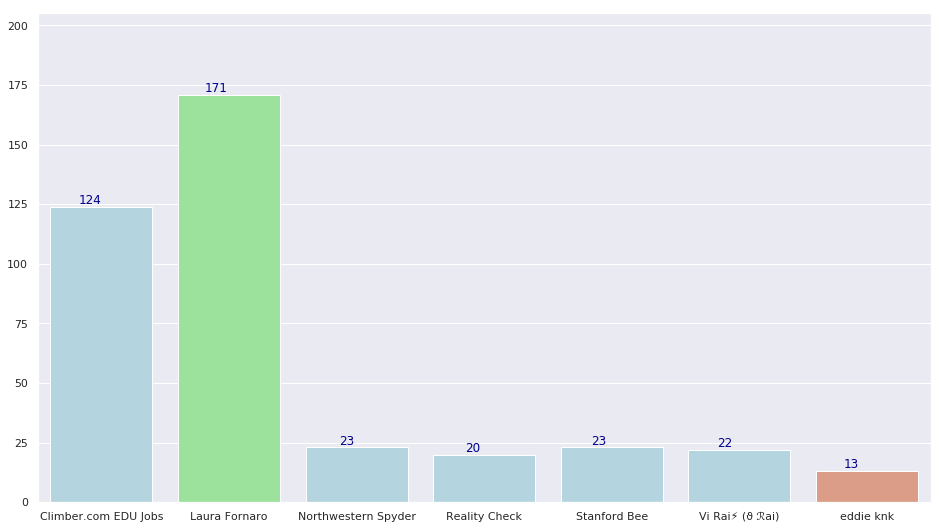

In [13]:
user_subset = user_grp[user_grp["id_str"] > 10]
user_subset.reset_index(drop=True, inplace=True)
f, ax = plt.subplots(1, 1, figsize=(16,9))
plot_bar(data=user_subset, x="user_name", y="id_str", ax=ax)

[USERNAME] Seems to be the most active user with several tweets

### Message Retweet

###### <font color=red> NOTE : CHANGE DATAFRAME TO uni_df WHEN RUNNING ONLINE </font>

In [14]:
user_rt_grp = tweets_df[["user_name", "retweet_count"]].groupby(by=["user_name"], as_index=False).sum()
user_rt_grp.reset_index(drop=True, inplace=True)
display(user_rt_grp.head())

# user_rt_subset = user_rt_grp[user_rt_grp["retweet_count"] > 10]
# user_rt_subset.reset_index(drop=True, inplace=True)
# display(user_rt_grp[user_rt_grp["retweet_count"] > 10])

,user_name,retweet_count
0,Anita El-Hara,0.0
1,Anneliese Kearney,0.0
2,BigDadio,0.0
3,Dusty Jorgenson,0.0
4,Edna Adelberg,0.0


In [15]:
# f, ax = plt.subplots(1, 1, figsize=(16,9))
# plot_bar(data=user_rt_subset, x="user_name", y="retweet_count", ax=ax)

### How much are they tweeting about the Universities vs. other topics?

In [16]:
prolific_users = user_subset["user_name"].unique()

In [18]:
cols = ["id_str", "user_id_str", "text", "user_name", "hashtags_cleaned", "uc_tweet", "uic_tweet", "mit_tweet", "stanford_tweet", "upenn_tweet", "nw_tweet", "uni_tweet"]
uvnu_df = tweets_df[tweets_df["user_name"].isin(prolific_users)][cols]
def tmpfun(row):
    if row:
        return 1
    else:
        return 0
uvnu_df["uni_tweet"] = uvnu_df["uni_tweet"].apply(tmpfun)
uvnu_df.shape

(514, 12)

In [19]:
tmp_df = uvnu_df[["user_name", "uni_tweet"]].groupby(by="user_name", as_index=False).agg(["sum", "count"])
tmp_df.columns = ["uni_tweets", "total_tweets"]
tmp_df.reset_index(drop=False, inplace=True)
tmp_df["ratio"] = tmp_df["uni_tweets"] / tmp_df["total_tweets"]
tmp_df

,user_name,uni_tweets,total_tweets,ratio
0,Climber.com EDU Jobs,124,192,0.645833
1,Laura Fornaro,171,171,1.000000
2,Northwestern Spyder,23,23,1.000000
3,Reality Check,20,33,0.606061
4,Stanford Bee,23,23,1.000000
5,Vi Rai⚡️ (ϑ ℛai),22,59,0.372881
6,eddie knk,13,13,1.000000


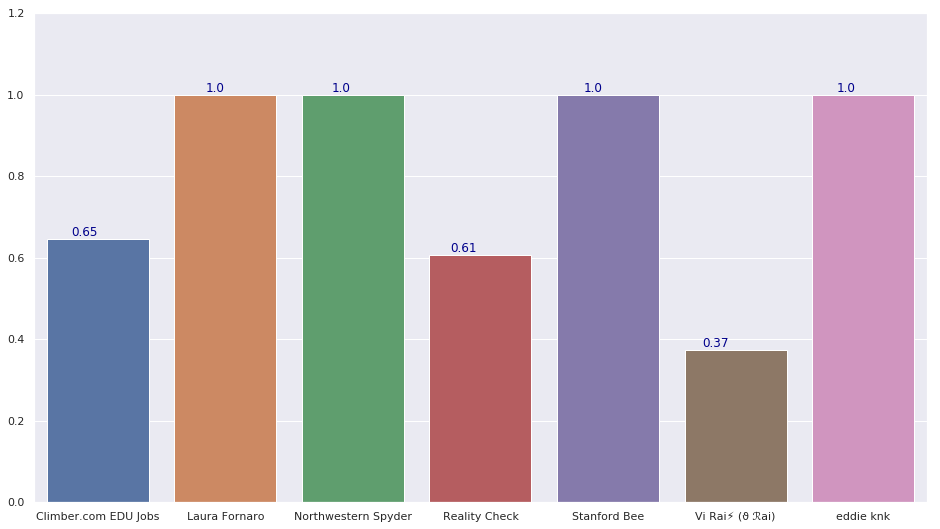

In [20]:
f, ax = plt.subplots(1,1,figsize=(16,9))
plot_bar(data=tmp_df, x="user_name", y="ratio", ax=ax, highlight_max_min=False)

## Where are these Twitterers located?
-  For UChicago
-  For other universities
-  Do you see any relationship between university locations and Twitterers’ locations?
-  Visualize the relationships

## What distinguishes University of Chicago Twitterers vs Twitterers who tweet about other universities
Visualize the trends

In [21]:
uni_df[uni_df["uc_tweet"]==True][["text", "text_len", "uc_tweet", "retweeted_status_user_id_str"]].head()

,text,text_len,uc_tweet,retweeted_status_user_id_str
443,RT @MirandaWeinberg: Morning! Today I'll be live from #UPennHearing on behalf of @GETUPgrads &am...,144,True,1158927727
3904,Susan Grants #artistsbooks are featured in our new #exhibition #Art in the Stacks now open until...,137,True,NaN
5232,@JohnBKing OSP-CP at #uchicago helps #firstgen students prepare for #college and #careers! #trio...,133,True,NaN
5513,RT @MirandaWeinberg: Morning! Today I'll be live from #UPennHearing on behalf of @GETUPgrads &am...,144,True,1158927727
16526,"INTRODUCING.....the ""DRAGON BERRY BLAST"" #banana #pineapple #coconut #raspberryswirl #chicagogra...",132,True,NaN


Text Lenghts and Re-tweets

## What are the timelines of these tweets? Do you see significant peaks and valleys?
Do you see data collection gaps?

In [26]:
uni_df[["created_at"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2350 entries, 348 to 832068
Data columns (total 1 columns):
created_at    2350 non-null object
dtypes: object(1)
memory usage: 116.7+ KB


In [49]:
uni_df["created_at"] = pd.to_datetime(uni_df['created_at'])

In [50]:
uni_df['created_month'] = uni_df['created_at'].map(lambda x: x.month)
uni_df['created_year'] = uni_df['created_at'].map(lambda x: x.year)
uni_df['created_date'] = uni_df['created_at'].map(lambda x: x.day)
uni_df['created_dayofweek'] = uni_df['created_at'].map(lambda x: x.weekday_name)
uni_df[["created_at", "created_dayofweek", "created_date", "created_month", "created_year"]].head()

,created_at,created_dayofweek,created_date,created_month,created_year
348,2017-06-22 14:17:26+00:00,Thursday,22,6,2017
373,2017-06-22 14:17:39+00:00,Thursday,22,6,2017
443,2017-06-22 14:18:07+00:00,Thursday,22,6,2017
473,2017-06-22 14:18:19+00:00,Thursday,22,6,2017
741,2017-06-22 14:20:09+00:00,Thursday,22,6,2017


In [51]:
uni_df.head()

,id_str,text,in_reply_to_status_id_str,in_reply_to_user_id_str,created_at,user_id_str,user_name,user_followers_count,user_favourites_count,user_statuses_count,user_friends_count,coordinates,favorite_count,entities_hashtags,favorited,retweet_count,retweeted,retweeted_status_user_id_str,retweeted_status_user_name,hashtags_cleaned,text_len,mit_tweet,stanford_tweet,nw_tweet,upenn_tweet,uc_tweet,uic_tweet,uni_tweet,created_month,created_year,created_day,created_date,created_dayofweek
348,8.778933e+17,RT @OriginalMcGill3: #AGTG EXTREMELY HONORED AND BLESSED TO RECIEVE AN OFFER FROM STANFORD UNIVE...,NaN,NaN,2017-06-22 14:17:26+00:00,24333184.0,Gabe,85.0,385.0,152.0,213.0,NaN,0.0,"[Row(indices=[21, 26], text='AGTG'), Row(indices=[103, 114], text='GoStanford')]",False,0.0,False,1104434276,Jonathan McGill,"[AGTG, GoStanford]",140,False,True,False,False,False,False,True,6,2017,22,22,Thursday
373,8.778933e+17,New algorithm generates folding patterns to produce any #3-D origami structure #MIT... https://t...,NaN,NaN,2017-06-22 14:17:39+00:00,588604189.0,Technolizer,880.0,0.0,117346.0,381.0,NaN,0.0,"[Row(indices=[79, 83], text='MIT')]",False,0.0,False,NaN,NaN,[MIT],134,True,False,False,False,False,False,True,6,2017,22,22,Thursday
443,8.778935e+17,RT @MirandaWeinberg: Morning! Today I'll be live from #UPennHearing on behalf of @GETUPgrads &am...,NaN,NaN,2017-06-22 14:18:07+00:00,274415582.0,Danielle Hanley,131.0,637.0,577.0,288.0,NaN,0.0,"[Row(indices=[54, 67], text='UPennHearing'), Row(indices=[133, 143], text='UChearing')]",False,0.0,False,1158927727,Miranda Weinberg,"[UPennHearing, UChearing]",144,False,False,False,True,True,False,True,6,2017,22,22,Thursday
473,8.778935e+17,#Stanford Scientists #Discover a #Way to #Convert #Carbon #Dioxide into #Clean #Burning #Ethanol...,NaN,NaN,2017-06-22 14:18:19+00:00,45817618.0,Ivan Kulikov,449.0,528.0,9451.0,358.0,NaN,0.0,"[Row(indices=[0, 9], text='Stanford'), Row(indices=[21, 30], text='Discover'), Row(indices=[33, ...",False,0.0,False,NaN,NaN,"[Stanford, Discover, Way, Convert, Carbon, Dioxide, Clean, Burning, Ethanol]",120,False,True,False,False,False,False,True,6,2017,22,22,Thursday
741,8.778940e+17,https://t.co/3fR9KmELE1 5 Life Hacks und Tricks mit Ballons | Tommy Tv #video #life #hacks #und ...,NaN,NaN,2017-06-22 14:20:09+00:00,366674576.0,HotVideo Deutschland,369.0,0.0,47474.0,0.0,NaN,0.0,"[Row(indices=[71, 77], text='video'), Row(indices=[78, 83], text='life'), Row(indices=[84, 90], ...",False,0.0,False,NaN,NaN,"[video, life, hacks, und, tricks, mit, ballons, tommy]",124,True,False,False,False,False,False,True,6,2017,22,22,Thursday


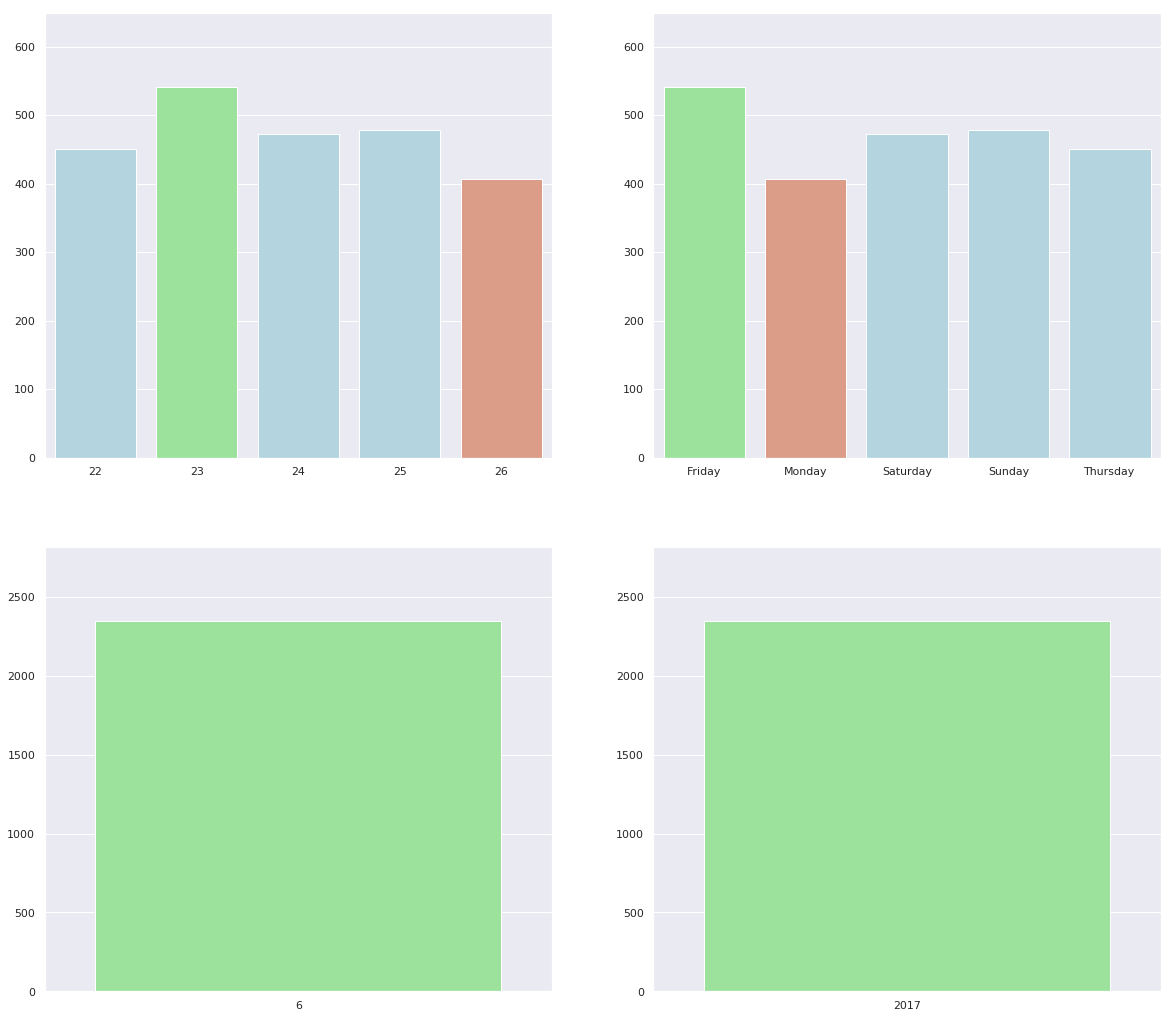

In [65]:
uni_df_date_grp = uni_df[["id_str", "created_date"]].groupby(by="created_date", as_index=False).count()
uni_df_dayofweek_grp = uni_df[["id_str", "created_dayofweek"]].groupby(by="created_dayofweek", as_index=False).count()
uni_df_month_grp = uni_df[["id_str", "created_month"]].groupby(by="created_month", as_index=False).count()
uni_df_year_grp = uni_df[["id_str", "created_year"]].groupby(by="created_year", as_index=False).count()

f, ax = plt.subplots(2,2,figsize=(20,18))
plot_bar(data=uni_df_date_grp, x="created_date", y="id_str", ax=ax[0][0], annot=False)
plot_bar(data=uni_df_dayofweek_grp, x="created_dayofweek", y="id_str", ax=ax[0][1], annot=False)
plot_bar(data=uni_df_month_grp, x="created_month", y="id_str", ax=ax[1][0], annot=False)
plot_bar(data=uni_df_year_grp, x="created_year", y="id_str", ax=ax[1][1], annot=False)

## How unique are the messages for each of these universities?
-  Are they mostly unique? Or mostly people are just copy-pasting the same text?
-  You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
-  Visualize message duplication (for each university – not between the universities)